## CV_Text Detection from Images Using OpenCV

In [1]:
# Install required model, the Easyocr model be chosen to recognize pictures
!pip install --upgrade pip
!pip install easyocr

In [2]:
!which tesseract

/opt/homebrew/bin/tesseract


In [3]:
# Import required libraries
import math
import cv2
import easyocr
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

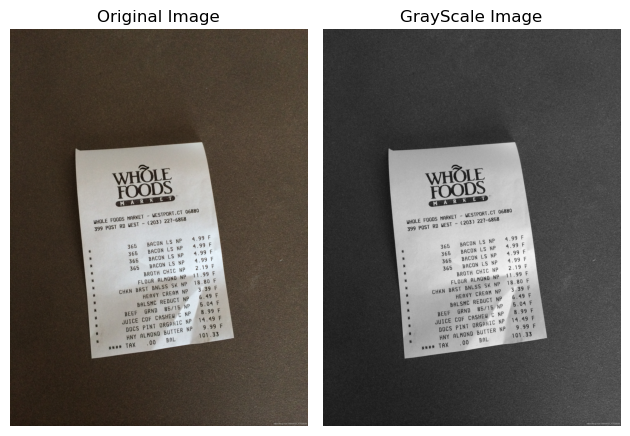

In [4]:
# Load the color image
img = cv2.imread('/Users/liuyanru/Desktop/CDS540/test file/Whole Foods.jpeg')

# Convert the image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display the original color image
plt.subplot(1, 2, 1)# Create a 1x2 layout for better display
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display the grayscale image
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('GrayScale Image')
plt.axis('off')

# Adjust layout to prevent image overlap
plt.tight_layout()
plt.show()

### Image processing to enhance text visibility

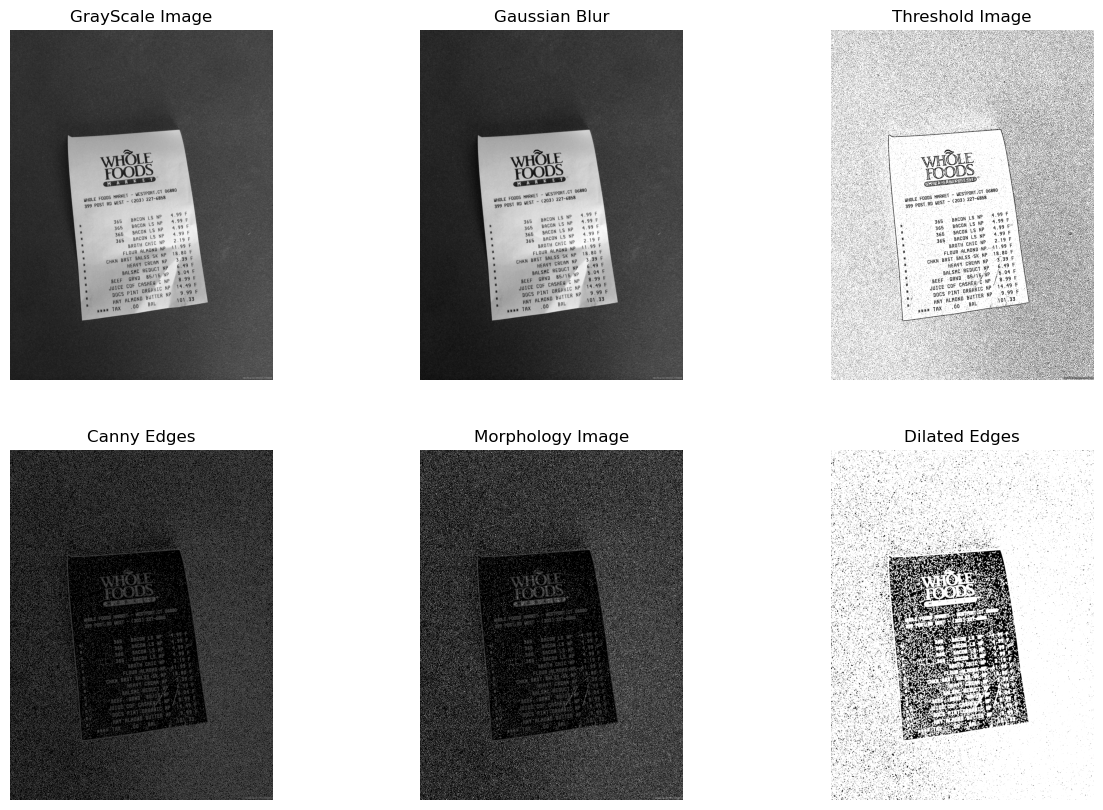

In [5]:
# Apply Gaussian blur to reduce noise
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 1)

# Apply adaptive thresholding to binarize the image
img_thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

# Apply Canny edge detection to enhance text edges
edges = cv2.Canny(img_thresh, 50, 150)

# Apply morphological operations (closing) to fill small gaps in the edges
kernel = np.ones((2, 2), np.uint8)
img_morph = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# Dilate the edges to strengthen them
dilated_kernel = np.ones((3, 3), np.uint8)
edges_dilate = cv2.dilate(img_morph, dilated_kernel, iterations=3)

# Display grayscale image
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('GrayScale Image')
plt.axis('off')

# Display blurred image
plt.subplot(2, 3, 2)
plt.imshow(img_blur, cmap='gray')
plt.title('Gaussian Blur')
plt.axis('off')

# Display thresholded image
plt.subplot(2, 3, 3)
plt.imshow(img_thresh, cmap='gray')
plt.title('Threshold Image')
plt.axis('off')

# Display edges detected by Canny
plt.subplot(2, 3, 4)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

# Display morphologically processed image
plt.subplot(2, 3, 5)
plt.imshow(img_morph, cmap='gray')
plt.title('Morphology Image')
plt.axis('off')

# Display dilated edges
plt.subplot(2, 3, 6)
plt.imshow(edges_dilate, cmap='gray')
plt.title('Dilated Edges')
plt.axis('off')


plt.show()

### Detect the largest quadrilateral contour in an image, draw the contour, and mark the corner points.

Detected corner points:
Point 1: [1576  929]
Point 2: [538 980]
Point 3: [ 670 2709]
Point 4: [1841 2539]


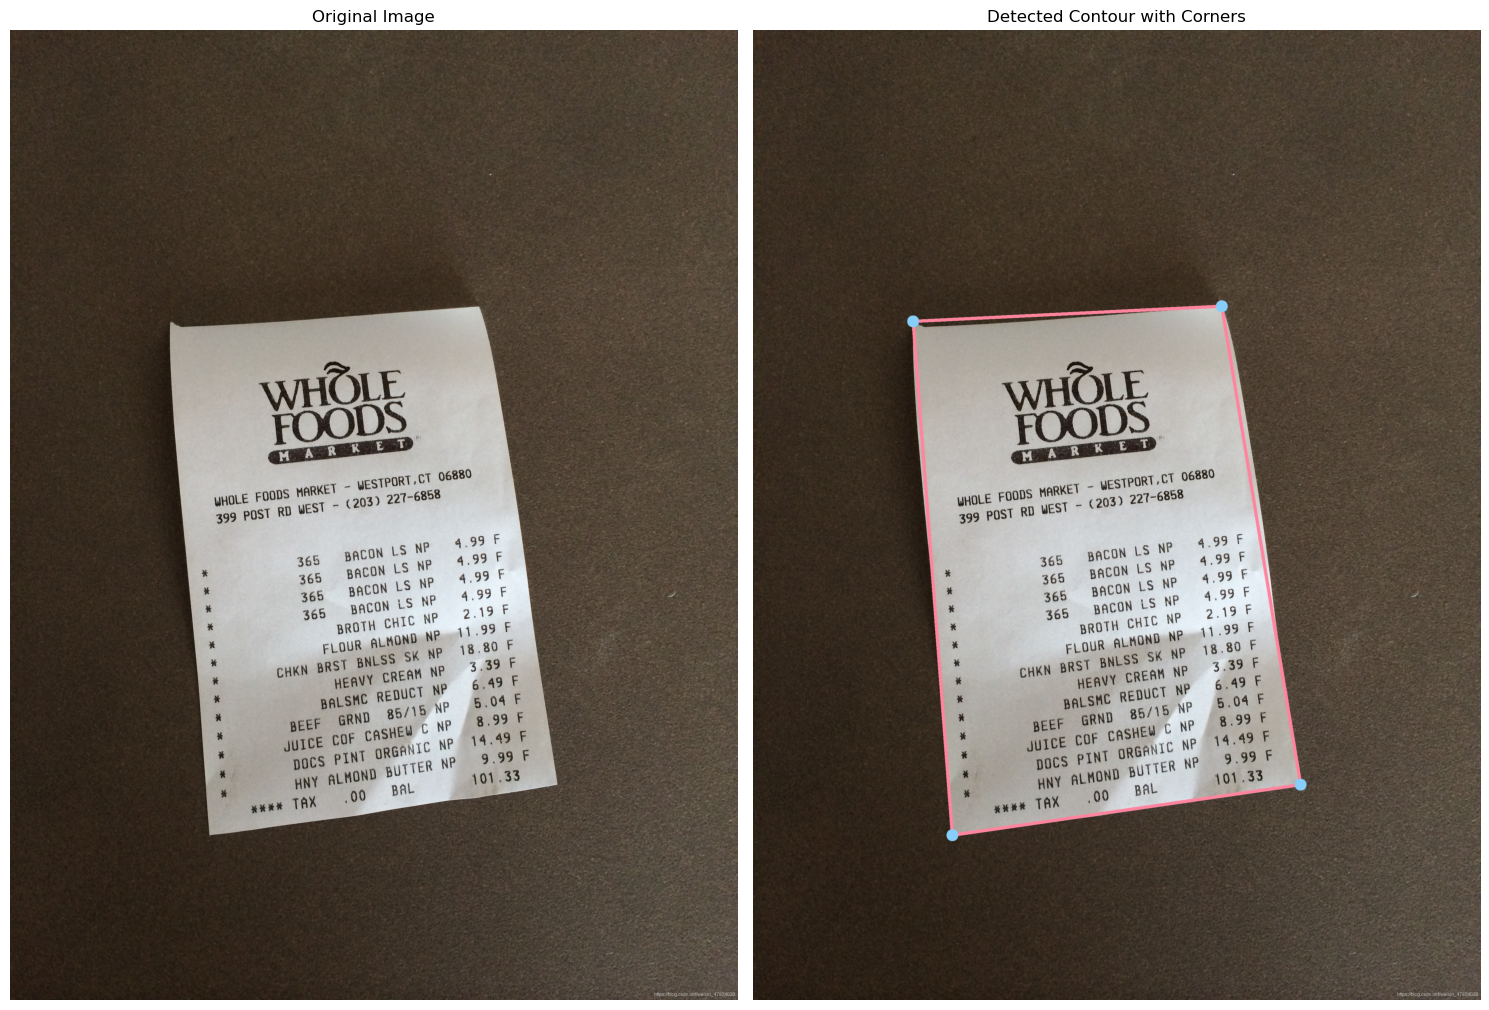

In [6]:
# Find Contours
# Find all contours in the binary edge image, RETR_EXTERNAL retrieves only external contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort Contours and Select the Largest One
# Sort contours by area in descending order, ensuring the first contour is the largest region in the image
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Draw the Largest Contour
# Copy the original image to prepare for drawing contours on the copy
img_contour = img.copy()
if contours:
    # Get the largest contour
    largest_contour = contours[0]
    
    # Approximate Polygon
    # Use polygon approximation to simplify the contour; 
    # Epsilon controls the approximation accuracy (2% of the contour length)
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)

    # Ensure it is a Quadrilateral
    # Check if the approximated polygon has 4 vertices to determine if it's a quadrilateral
    if len(approx) == 4:
        # Draw the approximated polygon (contour)
        # Draw the quadrilateral contour on the copied image with pink color and a line thickness of 10
        img_contour = cv2.drawContours(img_contour, [approx], -1, (159, 133, 255), 10)

        # Draw Corner Points
        for point in approx:
            cv2.circle(img_contour, tuple(point[0]), 20, (250, 206, 135), -1)  # Draw corner points in blue

        # Print detected corner points
        print("Detected corner points:")
        for i, point in enumerate(approx):
            print(f"Point {i+1}: {point[0]}")
    else:
        print("No quadrilateral detected.")
    

# Display the original image and result image
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB))
plt.title('Detected Contour with Corners')
plt.axis('off')

plt.tight_layout()
plt.show()


### Correct the quadrilateral region in the image through perspective transformation, making it appear as a front-facing rectangle.

Calculated width: 1182, height: 2029


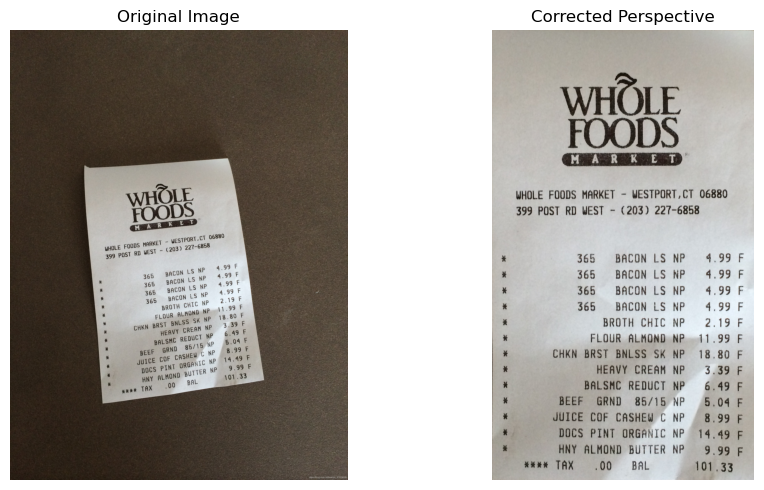

In [7]:
# Four corner points in clockwise order: top-left, top-right, bottom-left, bottom-right
pts1 = np.float32([[539, 981], [1577, 930], [671, 2709], [1841, 2538]])

# Calculate the transformed width and height
width1 = math.sqrt((1577 - 539) ** 2 + (930 - 981) ** 2)  # 上边的宽度
width2 = math.sqrt((1841 - 671) ** 2 + (2538 - 2709) ** 2)  # 下边的宽度
height1 = math.sqrt((1577 - 671) ** 2 + (930 - 2709) ** 2)  # 右边的高度
height2 = math.sqrt((539 - 1841) ** 2 + (981 - 2538) ** 2)  # 左边的高度

# Take the maximum values as final width and height
width = max(int(width1), int(width2))
height = max(int(height1), int(height2))

# Debug: print the width and height to ensure correctness
print(f"Calculated width: {width}, height: {height}")

# Four corner points of the target image
pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

# Modify the corner positions to adjust the perspective effect.
# Adjust the top-left point
pts2[0][1] -= 50  # Move the top-left corner up by 50 pixels.
# pts2[2][1] -= -20 #Move the bottom-left corner down by 20 pixels.
pts2[3][0] += 35  # Move the bottom-right corner to the right by 35 pixels..

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(pts1, pts2)

# Apply perspective transform
dst = cv2.warpPerspective(img, M, (width, height))

# Display the original and corrected images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title('Corrected Perspective')
plt.axis('off')

plt.tight_layout()
plt.show()


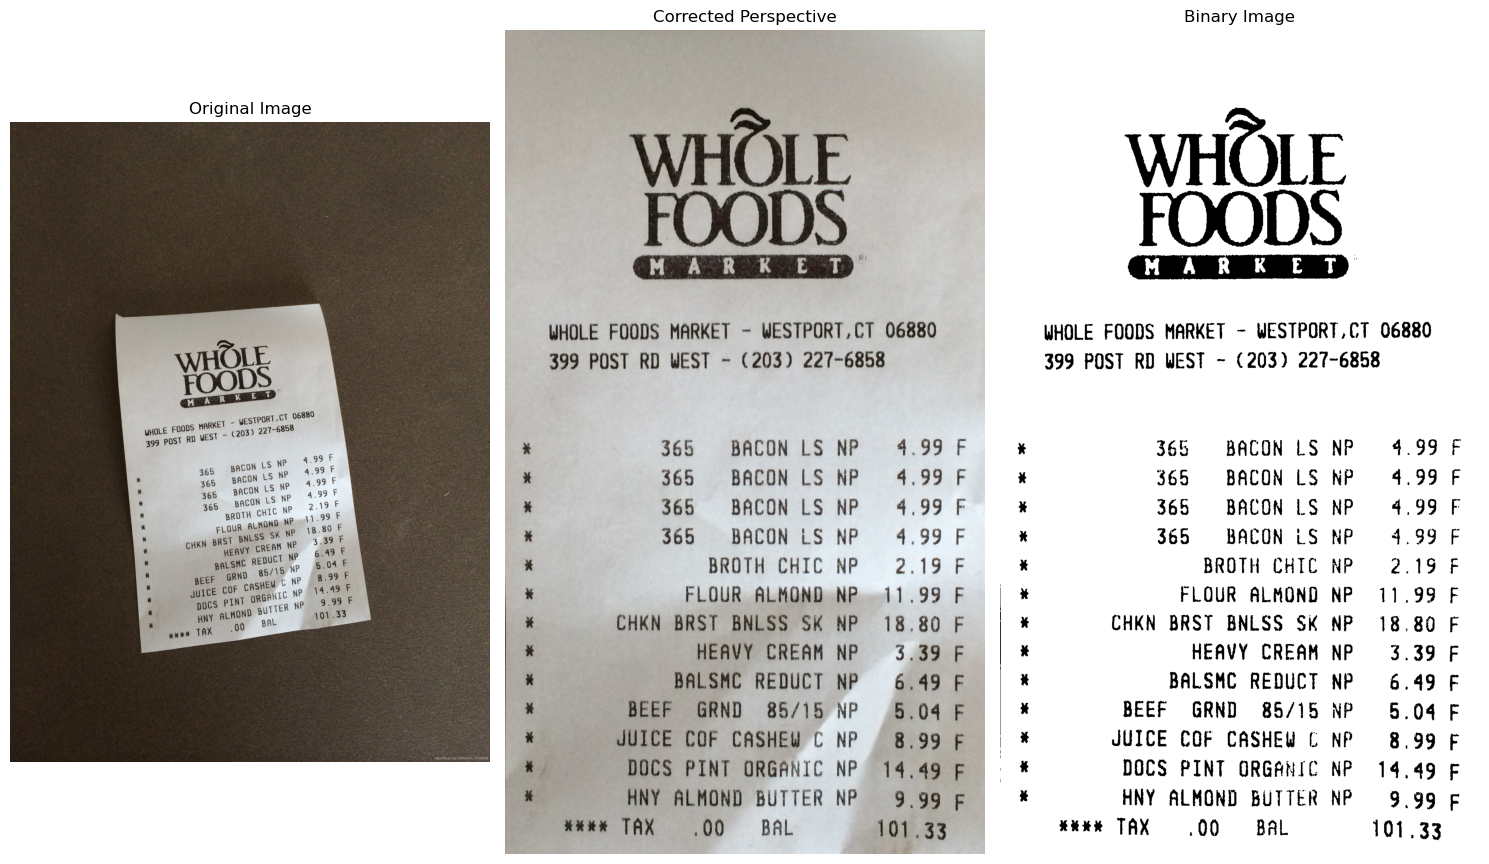

In [8]:
# Binarize the image
gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
_, binary = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)  # Fixed threshold binarization

# Display original, corrected, and binary images
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title('Corrected Perspective')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the binarized image
#cv2.imwrite('/Users/liuyanru/Desktop/CDS540/test file/OCR_binary.jpg', binary)


In [9]:
pytesseract.pytesseract.tesseract_cmd = '/usr/local/bin/tesseract'

### Extract and display text.

In [10]:
# Initialize EasyOCR reader, set language to English
reader = easyocr.Reader(['en'], gpu=False)

# Perform text recognition on the corrected image
result = reader.readtext(binary)

# Create a copy of the image for drawing bounding boxes and annotations
img_copy = dst.copy()

# Loop through the recognition results
for (bbox, text, prob) in result:
    # Get coordinates of the text area
    top_left = tuple([int(val) for val in bbox[0]])  # Top-left corner
    bottom_right = tuple([int(val) for val in bbox[2]])  # Bottom-right corner

    # Draw a bounding box on the image
    img_copy = cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 3)

    # Draw text annotations above the text box 
    text_position = (top_left[0], top_left[1] - 10)  # Place the text 10 pixels above the box
    cv2.putText(img_copy, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Print the extracted text and confidence level
    print(f"Detected Text: {text}, Probability: {prob:.2f}")


Using CPU. Note: This module is much faster with a GPU.


Detected Text: WHOLE, Probability: 0.62
Detected Text: FOODS, Probability: 0.96
Detected Text: A ^ R R € T, Probability: 0.09
Detected Text: WHOLE  FOODS  MARKET, Probability: 0.74
Detected Text: WESTPORT,CT  06880, Probability: 0.39
Detected Text: 399 POST RD WEST, Probability: 0.48
Detected Text: (203 ) 227-6858, Probability: 0.91
Detected Text: 365, Probability: 1.00
Detected Text: HAcOn, Probability: 0.17
Detected Text: LS, Probability: 0.89
Detected Text: NP, Probability: 1.00
Detected Text: 4 . 99, Probability: 0.65
Detected Text: F, Probability: 1.00
Detected Text: 365, Probability: 0.99
Detected Text: BAcOn, Probability: 0.19
Detected Text: LS, Probability: 0.91
Detected Text: MP, Probability: 0.99
Detected Text: 4 .99, Probability: 0.53
Detected Text: F, Probability: 1.00
Detected Text: 365, Probability: 1.00
Detected Text: BACON, Probability: 0.92
Detected Text: LS, Probability: 0.95
Detected Text: NP, Probability: 0.93
Detected Text: 4,99, Probability: 0.91
Detected Text: F,

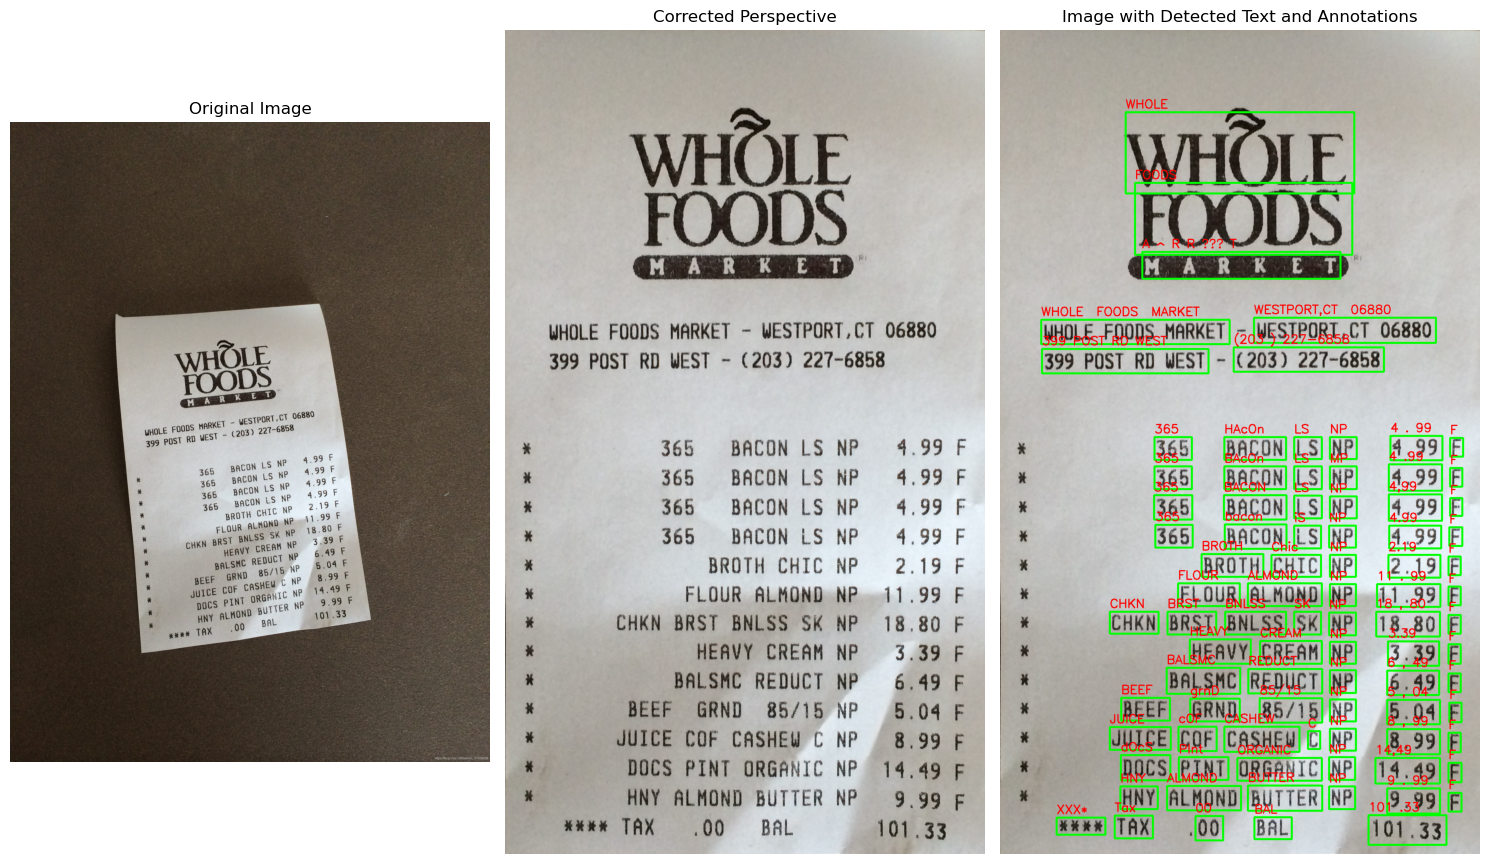

In [11]:
# Display the original image, corrected image, and image with annotations
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Corrected perspective image
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title('Corrected Perspective')
plt.axis('off')

# Image with bounding boxes and annotations
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Text and Annotations')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the image with bounding boxes and annotations
#cv2.imwrite('/Users/liuyanru/Desktop/CDS540/test file/OCR_with_text_boxes.jpg', img_copy)